# Pembalakan

EfficientNet-Unet trained on https://github.com/BioWar/Satellite-Image-Segmentation-using-Deep-Learning-for-Deforestation-Detection/tree/main/Dataset

## Checkpoints

All checkpoints can get at https://huggingface.co/malay-huggingface/pembalakan

## Preparation script

All scripts and notebooks can get at https://github.com/malaysia-ai/projects/tree/master/malaysia_ai_projects/pembalakan

## Install necessary requirements

```bash
pip3 install tensorflow>=1.15 malaya-boilerplate==0.0.15 skimage
```

In [1]:
from malaysia_ai_projects import pembalakan

## List available models

In [2]:
pembalakan.available_model()

,Size (MB),Test Loss
efficientnet-b4,79.9,0.08283
efficientnet-b4-quantized,20.7,0.08283
efficientnet-b2,66.4,0.09731
efficientnet-b2-quantized,17.1,0.09731


## Load model

```python
def load(model: str = 'efficientnet-b2', **kwargs):
    """
    Load Pembalakan model.

    Parameters
    ----------
    model : str, optional (default='efficientnet-b2')
        Model architecture supported. Allowed values:

        * ``'efficientnet-b4'`` - EfficientNet B4 + Unet.
        * ``'efficientnet-b4-quantized'`` - EfficientNet B4 + Unet with dynamic quantized.
        * ``'efficientnet-b2'`` - EfficientNet B2 + Unet.
        * ``'efficientnet-b2-quantized'`` - EfficientNet B2 + Unet with dynamic quantized.

    Returns
    -------
    result : malaysia_ai_projects.pembalakan.Model class
    """
```

In [3]:
model = pembalakan.load()

## Predict

```python
def predict(self, inputs: List[np.array]):
    """
    Parameters
    ----------
    input: List[np.array]
        List of np.array, should be size [H, W, 3], `H` and `W` can be dynamic.

    Returns
    -------
    result: List[np.array]
    """
```

In [4]:
from glob import glob

files = glob('example/pembalakan/*.png')
files

['example/pembalakan/perak.png',
 'example/pembalakan/0-114.png',
 'example/pembalakan/0-0.png',
 'example/pembalakan/0-119.png']

In [5]:
from skimage.io import imread

images = []
for f in files:
    images.append(imread(f))

In [6]:
outputs = model.predict(images)
len(outputs)

4

In [7]:
import matplotlib.pyplot as plt

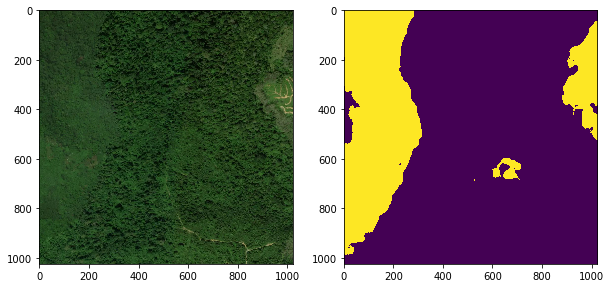

In [8]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.subplot(1,2,2)
plt.imshow(outputs[0][:,:,0])

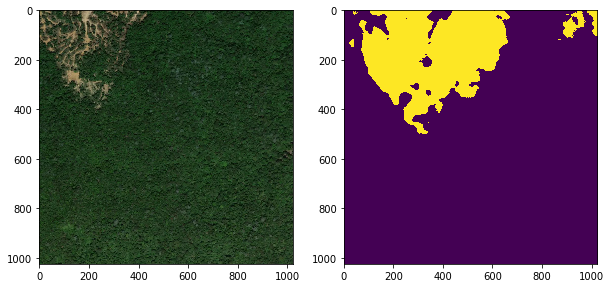

In [9]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(images[1])
plt.subplot(1,2,2)
plt.imshow(outputs[1][:,:,0])

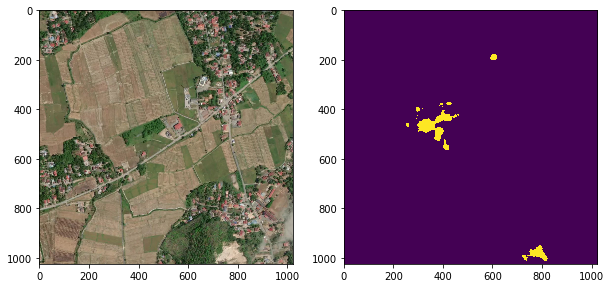

In [10]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(images[2])
plt.subplot(1,2,2)
plt.imshow(outputs[2][:,:,0])

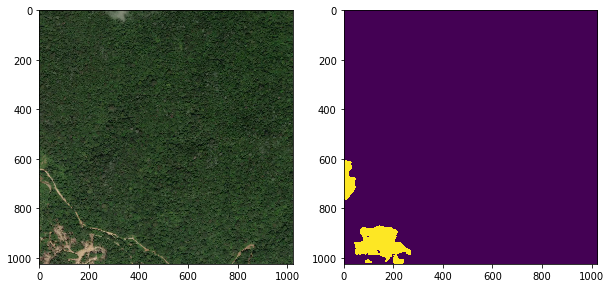

In [11]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(images[3])
plt.subplot(1,2,2)
plt.imshow(outputs[3][:,:,0])

In [12]:
images[3].shape, outputs[3][:,:,0].shape

((1024, 1024, 3), (1024, 1024))

## Download satellite image using Mapbox

In [14]:
# https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Tile_numbers_to_lon..2Flat.

import math
import requests
import shutil

def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

def download_img(lat, lon, zoom = 14, output_name = 'img.png'):
    x, y = deg2num(lat, lon, zoom)
    url = f'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/{zoom}/{x}/{y}@2x?title=true&logo=false&access_token=pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpejY4NXVycTA2emYycXBndHRqcmZ3N3gifQ.rJcFIG214AriISLbB6B5aw'
    response = requests.get(url, stream=True)
    with open(output_name, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)

In [15]:
output_name = 'example/pembalakan/test.png'
download_img(lat = 5.737522, lon = 100.388921, zoom = 15, output_name = output_name)
image = imread(output_name)

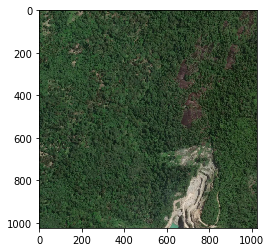

In [16]:
plt.imshow(image)

In [17]:
outputs = model.predict([image])

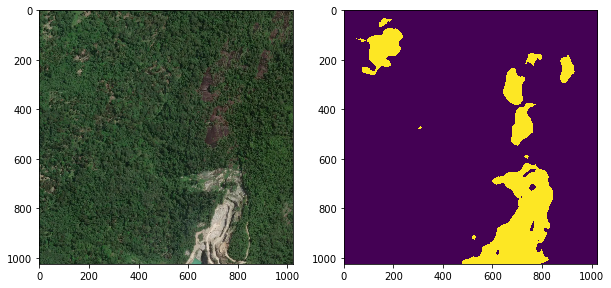

In [18]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(outputs[0][:,:,0])

## Calculate area of segmentation in km^2

### pixel to meter ratio

https://wiki.openstreetmap.org/wiki/Zoom_levels,

Stile = (C ∙ cos(latitude) / (2 ^ zoomlevel)) / size image

C = 40075016.686

malaysia latitude = 3.140853

zoomlevel = 15

I just take center of malaysia latitude, to get accurate result, take the actual latitude from the satellite image.

In [19]:
import math
import numpy as np

C = 40075016.686
malaysia_lat = 3.140853
per_pixel = np.abs(C * np.cos(malaysia_lat) / (2**15)) / 1024
per_pixel

1.194328240267381

So we know 1 pixel = 1.19m,

pixel = 1.19m

pixel^2 = 1.19m * 1.19m

pixel^2 = 1.4161m^2

pixel^2 / 1.4161 = m^2

Now, get total segmentation in term of pixels,

In [20]:
total_pixel = (outputs[0][:,:,0] > 0).sum()
total_pixel

115771

In [21]:
km_square = (total_pixel / (per_pixel * per_pixel)) / 1e6
km_square

0.08116193296736644